# Finding a good learning rate and batch size

After some talking to David Shih, I want to understand what batch size to select for our CNN. Too high of a batch size may cause thte model to overfit with every batch ([e.g., see this paper](https://arxiv.org/abs/1609.04836)). Too small of a batch size means that the batch gradients are too noisy, which may mean lots of wasted backpropagation steps. Furthermore, batch size covaries with learning rate ([see blog post](https://miguel-data-sc.github.io/2017-11-05-first/)).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display


In [2]:
PATH = os.path.abspath('..')

In [3]:
def parse_csv_multi_class_probabilities(path_to_csv):
    """Parse filenames and probabilities for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of probabilities in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    probabilities = [probs for _, *probs in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, probabilities, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, probabilities, idx2class = parse_csv_multi_class_probabilities(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    prob_arr = np.array(probabilities).astype(np.float32)
    
    return full_names, prob_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Initialize network: resnet34

I can try other architectures as well, but using the simplest resnet will probably give me a good idea of what's going on.

In [4]:
train_label_csv = f'{PATH}/catalogs/train-metaldist.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

In [5]:
arch = resnet34

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=8)

In [6]:
sz = 64
bs = 8

data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

In case I need to switch GPU device, I can quickly do it through the high-level command:

```python
# device number
device = 0
learner.model.cuda(device)
```

In [7]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

# Try the learning rate finder using different batch sizes

Note: this takes ~7 epochs worth of time, or about seven minutes on `pascal`.

In [9]:
learning_rates = []
losses = []
batch_sizes = np.logspace(start=3, stop=9, num=7, base=2, dtype=int)
for bs in batch_sizes:
    learn.set_data(get_data(sz, bs))
    learn.lr_find()
    
    learning_rates.append(learn.sched.lrs)
    losses.append(learn.sched.losses)
    

 90%|█████████ | 1083/1200 [01:00<00:06, 18.00it/s, loss=1.97] 

 90%|█████████ | 1083/1200 [01:00<00:06, 17.92it/s, loss=1.92] 

 91%|█████████ | 1087/1200 [01:02<00:06, 17.36it/s, loss=2.69] 

 89%|████████▉ | 1065/1200 [01:00<00:07, 17.63it/s, loss=2.06] 

 90%|█████████ | 1084/1200 [01:03<00:06, 17.07it/s, loss=1.8]  

 89%|████████▉ | 1070/1200 [01:02<00:07, 17.19it/s, loss=2.08] 

 90%|████████▉ | 1077/1200 [01:01<00:07, 17.48it/s, loss=2.41] 

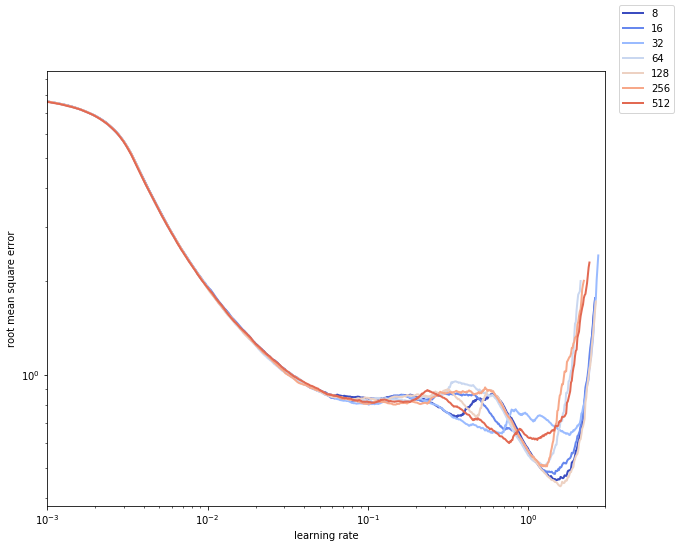

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

for i, bs in enumerate(batch_sizes):
    ax.plot(learning_rates[i], losses[i], label=f'{bs}', c=plt.cm.coolwarm(i/7), lw=2)

ax.set_xscale('log')
ax.set_xlim(1e-3, 3e0)
ax.set_yscale('log')

ax.set_xlabel('learning rate')
ax.set_ylabel('root mean square error')

fig.legend();

Okay now this is really interesting. The learning rate plateaus around $10^{-1}$ and even rises again, but then finds another minimum around a value of $1$. It looks like the lowest loss is actually found by batch sizes 128, then 8, then 16, then 256. That's really quite strange.

In [22]:
# find out which batch size led to the most minimal loss
batch_sizes[np.argsort([np.min(losses_) for losses_ in losses])]

array([128,   8,  16, 256,  64, 512,  32])

# Test batch size vs learning rate after a "warm start"

Here I will train for one epoch using a learning rate of $10^{-2}$ and with the given batch size, and then look at the learning rate finder.

In [26]:
learning_rates = []
losses = []
batch_sizes = np.logspace(start=3, stop=9, num=7, base=2, dtype=int)
for bs in batch_sizes:
    learn = ConvLearner.pretrained(arch, get_data(sz, bs))
    learn.fit(1e-2, 1)
    
    learn.lr_find(start_lr=1e-6)
    
    learning_rates.append(learn.sched.lrs)
    losses.append(learn.sched.losses)

epoch      trn_loss   val_loss                                 
    0      0.396069   0.141492  


 91%|█████████ | 1093/1200 [01:05<00:06, 16.70it/s, loss=1.58] 

epoch      trn_loss   val_loss                                 
    0      0.393066   0.142895  


 91%|█████████▏| 1097/1200 [01:04<00:06, 16.93it/s, loss=1.73] 

epoch      trn_loss   val_loss                                 
    0      0.405681   0.151359  


 91%|█████████ | 1094/1200 [01:03<00:06, 17.29it/s, loss=1.55] 

epoch      trn_loss   val_loss                                 
    0      0.403367   0.137277  


 91%|█████████ | 1090/1200 [01:04<00:06, 16.96it/s, loss=1.51] 

epoch      trn_loss   val_loss                                 
    0      0.403635   0.160006  


 91%|█████████▏| 1096/1200 [01:03<00:06, 17.28it/s, loss=1.72] 

epoch      trn_loss   val_loss                                 
    0      0.413856   0.137591  


 91%|█████████ | 1093/1200 [01:00<00:05, 18.15it/s, loss=1.53] 

epoch      trn_loss   val_loss                                 
    0      0.396582   0.141952  


 91%|█████████▏| 1097/1200 [01:20<00:07, 13.71it/s, loss=1.66] 

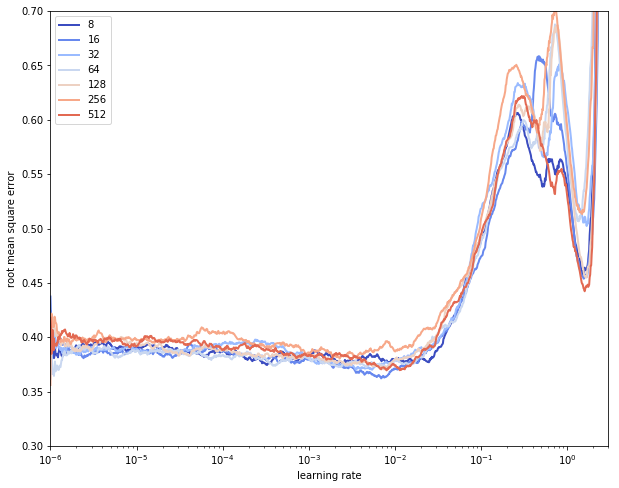

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

for i, bs in enumerate(batch_sizes):
    ax.plot(learning_rates[i], losses[i], label=f'{bs}', c=plt.cm.coolwarm(i/7), lw=2)

ax.set_xscale('log')
ax.set_xlim(1e-6, 3e0)
#ax.set_yscale('log')
ax.set_ylim(0.3, 0.7)

ax.set_xlabel('learning rate')
ax.set_ylabel('root mean square error')

plt.legend();

This has also been kind of strange. The loss is still decreasing at a learning rate of $10^{-3}$, but then has this other local minimum near 1 again. Perhaps it makes more sense to actually save the fit losses after 1 epoch.

# Test batch size vs  training
I will do 3 epochs of training using cosine annealing throughout the entire cycle. To save time I will only try batch sizes of 32, 128, and 512.

In [50]:
batch_sizes = [32, 128, 512]
lr = 0.1

train_losses = []
for bs in batch_sizes:
    learn = ConvLearner.pretrained(arch, get_data(sz, bs))
    learn.fit(lr, 1, cycle_len=3)
    
    train_losses.append(learn.sched.losses)

epoch      trn_loss   val_loss                                 
    0      0.134896   0.108755  
    1      0.113469   0.10351                                  
    2      0.108542   0.102703                                 


epoch      trn_loss   val_loss                                 
    0      0.130763   0.112617  
    1      0.108931   0.103324                                 
    2      0.110171   0.102631                                 


epoch      trn_loss   val_loss                                 
    0      0.131923   0.119937  
    1      0.111096   0.104085                                 
    2      0.10645    0.102607                                 


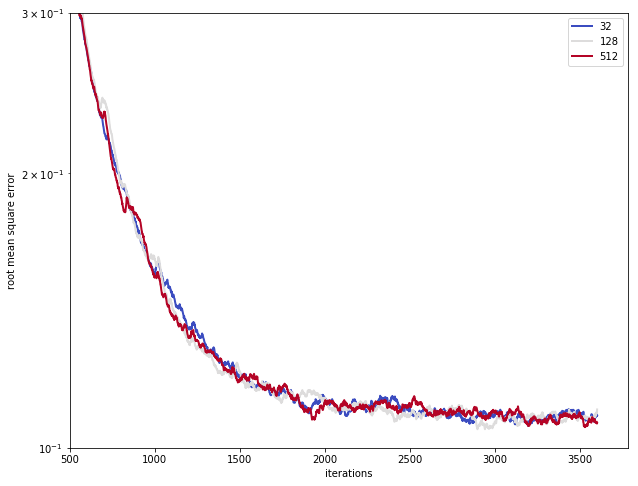

In [68]:
fig, ax = plt.subplots(figsize=(10, 8))

for i, bs in enumerate(batch_sizes):
    ax.plot(train_losses[i], label=f'{bs}', c=plt.cm.coolwarm(i/2), lw=2)

    
ax.set_xlabel('iterations')
ax.set_xlim(500, )
ax.set_ylabel('root mean square error')
ax.set_yscale('log')
ax.set_ylim(0.1, 0.3)

plt.legend();

Two things learned:
1. start off with a learning rate of 0.1, not 0.01
2. batch size appears not to make a big difference (yet).